# Notebook Monica

# Análise de Dados usando Aprendizagem Máquina

Este trabalho consiste na análise de um conjunto de dados, através da utilização de algoritmos de aprendizagem máquina, usando o Python como linguagem de programação. Este Jupyter Notebook está organizado em secções, que inclui os passos da análise realizada e explica muito sucintamente os procedimentos realizados e decisões tomadas ao longo da análise.

# Introdução

## Seleção dos Dados e Contexto do Trabalho

Para a execução deste trabalho, foi selecionado o conjunto de dados da Competição "Novozymes Enzyme Stability Prediction" na plataforma Kaggle. É possível visualizar a [Competição e Dados correspondentes aqui](https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/data).

O objetivo desta competição é desenvolver modelos que possam prever a termoestabilidade de variantes enzimáticas. Os dados de termoestabilidade medidos experimentalmente (temperatura de fusão) incluem sequências naturais, bem como sequências modificadas com mutações.

O conjunto de dados de teste contém temperaturas de fusão experimental de mais de 2.413 variantes de mutação única de uma enzima (GenBank: KOC15878.1), obtido pela Novozymes A/S. A sequência de aminoácidos do tipo selvagem é:

    VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK


Para esta competição foram dado vários ficheiros para o dessenvolvimento deste trabalho. Nomeadamente:

- `train.csv`: o conjunto de dados de treino com as seguintes colunas (features):
    - `seq_id`: identificador único de cada variante da enzima
    - `protein_sequence`: sequência de aminoácidos de cada variante da enzima. A estabilidade da proteína (`tm`) é determinada pela sua sequência.
    - `pH`: escala de acidez em que a estabilidade de cada variante da enzima foi medida.
    - `data_source`: fonte onde os dados foram publicados
    - `tm`: feature alvo - estabilidade de cada variante da enzima (valores mais altos correspondem a uma maior estabilidade).
    
- `train_updates_20220929.csv`: ficheiro de correção dos dados de treino, onde algumas linhas têm os valores de `pH` e `tm` trocados, para além de ter identificadas as linhas com valores NaN. Para mais detalhes, é possível verificar a [explicação original aqui](https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/356251).

- `test.csv`: o conjunto de dados de teste com as colunas `seq_id` e `protein_sequence`, emq ue o objetivo é prever o valor de `tm` para cada variante da enzima.

- `sample_submission.csv`: um ficheiro de amostra de submissão, com a formatação correta em que o `seq_id` corresponde aos mesmos do ficheiro `test.csv`.

- `wildtype_structure_prediction_af2.pdb`: ficheiro que contém informação sobre a estrutura 3D da enzima, prevista por AlphaFold.

## Importação de Packages Necessários



In [1]:
#Imports
from utils.func import swap_ph_tm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.func import *
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# from utils.kmers import KMer_prot
from sklearn.preprocessing import StandardScaler
from propy import PyPro

## Exploração Inicial de Dados e Pré-processamento

Esta etapa corresponde aos seguintes objetivos:
- descrição e caracterização dos dados atribuídos de acordo com a documentação/literatura existente;
- descrição sucinta das características dos dados disponíveis a partir da análise exploratória inicial;
- descrição dos passos de preparação dos dados e pré-processamento;
- gráficos exploratórios iniciais que ilustram as principais características dos dados.

In [2]:
#First lets see the data!

#Train dataframe
train = pd.read_csv("data/train.csv",index_col="seq_id")
#Test dataframe
test = pd.read_csv("data/test.csv",index_col="seq_id")

In [3]:
train.head()

,protein_sequence,pH,data_source,tm
seq_id,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [4]:
test.head()

,protein_sequence,pH,data_source
seq_id,,,
31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


In [5]:
print(f"Train data is divided in {train.shape[0]} lines and {train.shape[1]} columns")
print(f"Test data is divided in {test.shape[0]} lines and {test.shape[1]} columns")
print(f"Labels: {[labels for labels in train.columns]}")

Train data is divided in 31390 lines and 4 columns
Test data is divided in 2413 lines and 3 columns
Labels: ['protein_sequence', 'pH', 'data_source', 'tm']


In [6]:
len(pd.unique(train["data_source"]))

325

In [7]:
test.describe()

,pH
count,2413.0
mean,8.0
std,0.0
min,8.0
25%,8.0
50%,8.0
75%,8.0
max,8.0


In [8]:
train.describe()

,pH,tm
count,31104.000000,31390.000000
mean,6.892339,49.147337
std,1.612225,14.010089
min,1.990000,-1.000000
25%,7.000000,42.100000
50%,7.000000,48.000000
75%,7.000000,53.800000
max,64.900000,130.000000


In [10]:
print(train.data_source)

seq_id
0        doi.org/10.1038/s41592-020-0801-4
1        doi.org/10.1038/s41592-020-0801-4
2        doi.org/10.1038/s41592-020-0801-4
3        doi.org/10.1038/s41592-020-0801-4
4        doi.org/10.1038/s41592-020-0801-4
                       ...                
31385    doi.org/10.1038/s41592-020-0801-4
31386    doi.org/10.1038/s41592-020-0801-4
31387    doi.org/10.1038/s41592-020-0801-4
31388    doi.org/10.1038/s41592-020-0801-4
31389    doi.org/10.1038/s41592-020-0801-4
Name: data_source, Length: 31390, dtype: object


In [12]:
sources = {}
count = 1
for n, i in enumerate(train.data_source):
    if i not in sources.keys():
        sources[i] = count
        train.data_source[n] = sources[i]
        count += 1
    else:
        train.data_source[n] = sources[i]

print(train.data_source)

/tmp/ipykernel_15806/2501429321.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.data_source[n] = sources[i]
/tmp/ipykernel_15806/2501429321.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.data_source[n] = sources[i]


seq_id
0        1
1        1
2        1
3        1
4        1
        ..
31385    1
31386    1
31387    1
31388    1
31389    1
Name: data_source, Length: 31390, dtype: object


In [13]:
print(min(train.data_source))
print(max(train.data_source))

1
325


TypeError: 'value' must be an instance of str or bytes, not a float

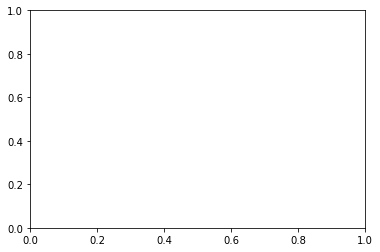

In [11]:
plt.hist(train.data_source, bins=325)
plt.show()

### Swap pH e tm

Aqui é possível verificar que a variável pH tem erros no dataset "train", uma vez que o seu máximo é de 64.9 (valor impossível de obter). Segundo a fonte dos dados, a variável pH e tm tem alguns exemplos com os valores trocados. Assim, é necessário fazer a troca desses valores nas sequências identificadas (dataset "train_updates").

In [22]:
update_train= pd.read_csv("data/train_updates_20220929.csv",index_col="seq_id")
train= swap_ph_tm(train,update_train)


In [23]:
print(f"Labels: {[labels for labels in train.columns]}")
print(f"Labels: {[labels for labels in test.columns]}")

Labels: ['protein_sequence', 'pH', 'data_source', 'tm']
Labels: ['protein_sequence', 'pH', 'data_source']


In [13]:
print("Remove data_source")
train= train.drop(columns="data_source")
test= test.drop(columns="data_source")
print(f"Train data is divided in {train.shape[0]} lines and {train.shape[1]} col")
print(f"Test data is divided in {test.shape[0]} lines and {test.shape[1]} col")
print("We want to predict tm values for test data")

Remove data_source
Train data is divided in 31390 lines and 3 col
Test data is divided in 2413 lines and 2 col
We want to predict tm values for test data


In [111]:
print(train.isnull().sum().sort_values(ascending=False))
print(test.isnull().sum().sort_values(ascending=False))
#There are some missing values in train
#Data_source values are not that important

pH                  286
protein_sequence      0
data_source           0
tm                    0
dtype: int64
protein_sequence    0
pH                  0
data_source         0
dtype: int64


In [105]:
missing_data= train[train["pH"].isnull()]
missing_data

,protein_sequence,pH,data_source,tm
seq_id,,,,
484,ARINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,NaN,5,84.0
6215,MASHKLLVTPLKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,35,73.8
6216,MASHKLLVTPPKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,35,85.5
6217,MASHKLLVTPPKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,35,67.1
6218,MASHKLLVTPPKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,35,83.2
...,...,...,...,...
28753,MVLKQRANYLGFLIVFFTAFLVEAVPIKRQSNSTVDSLPPLIPSRT...,NaN,317,58.9
28754,MVLKQRANYLGFLIVFFTAFLVEAVPIKRQSNSTVDSLPPLIPSRT...,NaN,317,59.4
28755,MVLKQRANYLGFLIVFFTAFLVEAVPIKRQSNSTVDSLPPLIPSRT...,NaN,317,57.8


In [88]:
train= train.drop((missing_data).index)
train
#Podemos remover também a data_source? Não deve de trazer nada de relevante para a analise dos dados

,protein_sequence,pH,data_source,tm
seq_id,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,1,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,1,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,1,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,1,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,1,49.5
...,...,...,...,...
31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,1,51.8
31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,1,37.2
31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,1,64.6
